How would you build a machine learning algorithm to solve the following types of problems?

- Predict which medal athletes will win in the olympics.
- Predict how a shoe will fit a foot (too small, perfect, too big).
- Predict how many stars a critic will rate a movie.

If you reach into your typical toolkit, you'll probably either reach for regression or multiclass classification. For regression, maybe you treat the number of stars (1-5) in the movie critic question as your target, and you train a model using mean squared error as your loss function. For multiclass classification, maybe you treat bronze, silver, and gold medals as three separate classes and train a model with cross entropy loss.

While these approaches _can_ work, they ignore a fundamental aspect of the prediction targets in the proposed problems: the targets have _ordinal_ relationships to each other. There is a larger difference between bronze and gold than silver and gold. Similarly, from the point of view of the model that we would like to build, our wrong predictions should have ordinal relationships. If we predict that a piece of clothing will be too big on a customer and we get our prediction wrong, then it's more likely that the clothing fit the customer than that we got things entirely wrong sucht that the clothing was too small.

This class of problems is called _ordinal regression_. While commonly seen in industry, the tooling and education around using these models is somewhat lacking. As well, the tools that do exist are rather inflexible in that one is limited in the types of models and techniques that can be used. I have a somewhat idealistic goal of taking all of the bespoke machine learning methods for which people used to solve via linear models and manually calculated gradients and instead rewrite these models using a deep learning framework with custom loss functions optimizable by stochastic gradient descent (SGD). This would allow people to move beyond linear models (to, say, deep neural networks) and enjoy all of the benefits of SGD (ADAM, batch norm, scale, etc...). As well, I'd like to do this all in a [scikit-learn](https://scikit-learn.org)-compatible way because I just love their API.

To illustrate my point, let's look at the only scikit-learn-compatible library I could find that fits ordinal regression models, [mord](https://pythonhosted.org/mord/). Don't get me wrong, this library is great and quick and created by a [verifiable expert](http://fa.bianp.net/blog/2015/on-the-consistency-of-ordinal-regression-methods/) in ordinal regression models. However, all of the models available are linear models with L2 regularization. What if I want to throw a deep learning model in there? What if I want to induce sparsity with LASSO? I would have to manually calculate the objective functions and associated gradients and create a brand new class in the library. If I can instead suitably define a loss function compatible with ordinal regression, then I can use any of the deep learning frameworks that use autodifferentiation to optimize whatever model I want. And I'd like to be able to scale this to large data, which rules out the [stan](https://multithreaded.stitchfix.com/blog/2017/12/13/latentsize/) and [pymc3](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.OrderedLogistic) implementations.

So that's what I did, and I created a small library [spacecutter](https://github.com/EthanRosenthal/spacecutter) to implement ordinal regression models in PyTorch. In this post, I will explain how ordinal regression works, show how I impemented the model in PyTorch, wrap the model with [skorch](http://skorch.readthedocs.io/) to turn it into a scikit-learn estimator, and then share some results on a canned dataset.

## From Binary to Ordinal Regression

There are a number of ways to solve ordinal regression problems, and I will only walk through one method in this post. I found this [paper](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.124.9242) that was referenced in `mord` to provide a good introduction to how to solve these problems. For the technique used in this section, I referenced this [paper](http://jmlr.org/papers/v18/15-495.html) by the author of `mord`, [Fabian Pedregosa](http://fa.bianp.net/). Although he did not create this technique, the referenced papers were behind paywalls, so I can't vouch for them.

The main idea behind ordinal regression is that we learn how to cut our prediction space up using `cutpoints`. But before we get into that, let's quickly review binary logistic regression where we have two target classes, `0` and `1`. Recall that in logistic regression, we have some linear model $f(\mathbf{X}) = \mathbf{X} \cdot \boldsymbol{\beta} $ that turns a design matrix $\mathbf{X}$ and a vector of coefficients $\boldsymbol{\beta}$ into a single number that lies somewhere between negative and positive infinity ($\mathbb{R}$). The output of this linear model is then passed through a logistic function $\sigma$ which maps the range of values between 0 and 1:

$$ \sigma(f(\mathbf{X})) = \frac{1}{1 + e^{-\mathbf{X} \cdot \boldsymbol{\beta} }} $$

This function looks like as follows:

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [2]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

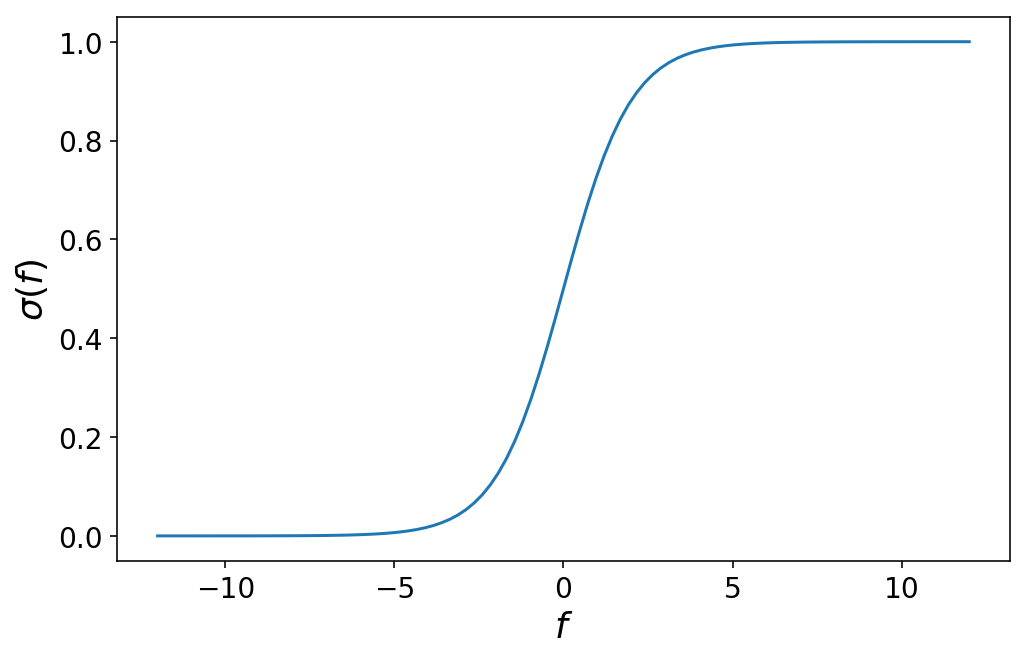

In [3]:
num_points = 101
f = np.linspace(-12, 12, num_points)
sigma = lambda f: 1 / (1 + np.exp(-f))
plt.plot(f, sigma(f));
plt.ylabel('$\sigma(f)$');
plt.xlabel('$f$');

Through some math, it's possible to convince yourself that picking a particular value of `f` corresponds to the _probability_ that the observation that produced `f` belongs to class `1`. We'll write that as

$$P(y = 1) = \sigma(f)$$

The probability that the observation belongs to class `0` is 

$$
\begin{aligned}
P(y = 0) & = 1 - P(y = 1) \cr
         & = 1 - \sigma(f)
\end{aligned}
$$

The value of $f = 0$ is special in that it marks the exact crossover point where the observation has a 50% probability of belonging to either class `0` or class `1`. In the language of ordinal regression, we can call $f = 0$ a _cutpoint_ which divides our prediction space between class `0` and `1`:

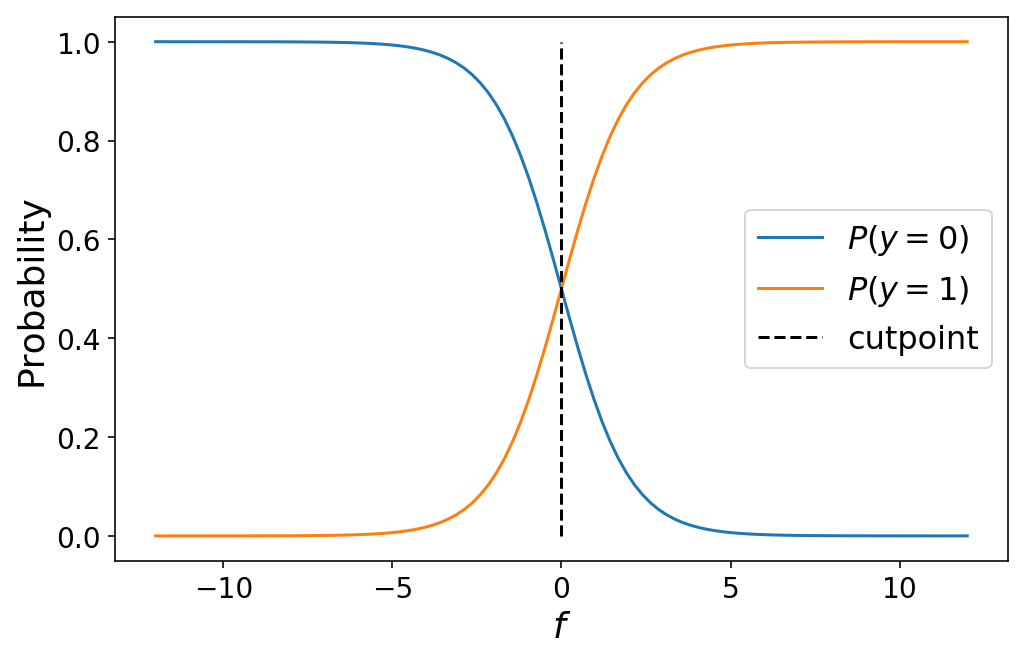

In [4]:
plt.plot(f, 1 - sigma(f));
plt.plot(f, sigma(f));
plt.plot((0, 0), (0, 1), 'k--');
plt.legend(['$P(y = 0)$', '$P(y = 1)$', 'cutpoint'])
plt.ylabel('Probability');
plt.xlabel('$f$');

Moving from binary classification to ordinal regression with 3+ classes involves simply defining more cutpoints to chop up our prediction space into "class probability" space. For $K$ classes, we will have $K - 1$ cutpoints. The probability that an observation belongs to class $k$ is given by the _cumulative logistic link function_:

$$
P(y = k) = 
  \begin{cases}
    \sigma(c_0 - f(\mathbf{X}))\,, \text{if } k = 0 \cr
    \sigma(c_{k} - f(\mathbf{X})) - \sigma(c_{k - 1} - f(\mathbf{X})) \,, \text{if } 0 < k < K \cr
    1 - \sigma(c_{K - 1} - f(\mathbf{X})) \,, \text{if } k = K \cr
  \end{cases}
$$

One thing to note is that this perfectly collapses to binary classification in the event that we only have two classes (try it out for yourself!). The following plot shows the class probabilities for a three-class ordinal regression model:

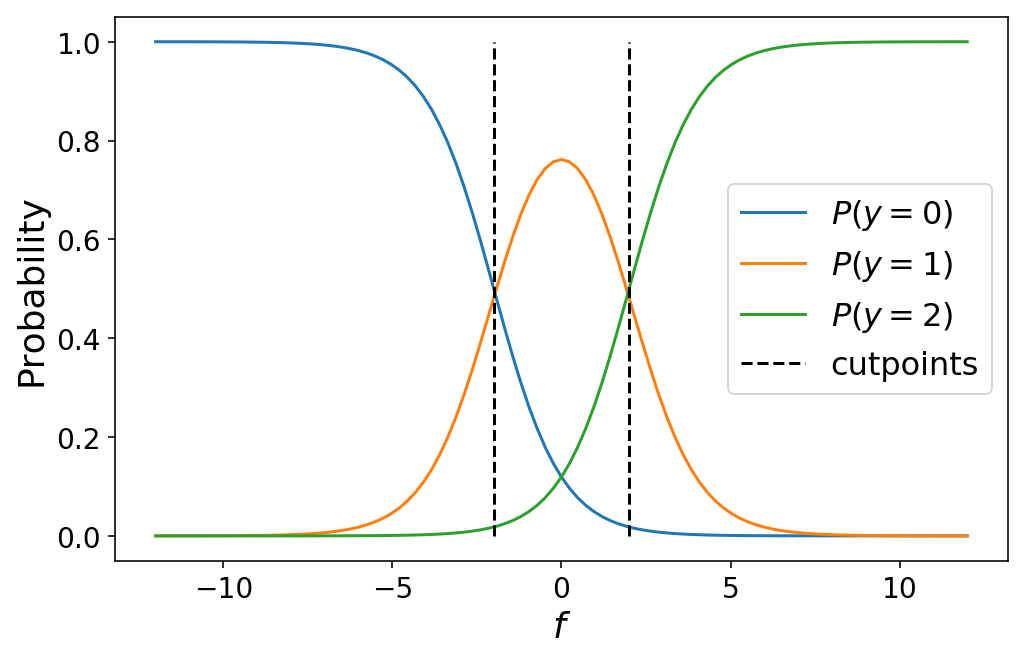

In [5]:
def plot_ordinal_classes(f, cutpoints):
    num_classes = len(cutpoints) + 1
    labels = []
    for idx in range(num_classes):
        
        if idx == 0:
            plt.plot(f, sigma(cutpoints[0] - f));
        elif idx == num_classes - 1:
            plt.plot(f, 1 - sigma(cutpoints[-1] - f));
        else:
            plt.plot(f, sigma(cutpoints[idx] - f) - sigma(cutpoints[idx - 1] - f));
            
        labels.append(f'$P(y = {idx})$')
        
    for c in cutpoints:
        plt.plot((c, c), (0, 1), 'k--')
        
    labels.append('cutpoints')
    plt.legend(labels);
    plt.ylabel('Probability');
    plt.xlabel('$f$');
    
cutpoints = [-2, 2]
plot_ordinal_classes(f, cutpoints)

While I defined the cutpoints by hand above, in practice we would _learn_ the optimal values for the cutpoints as part of our machine learning problem (which we'll talk about in the next section). Varying the cutpoints varies the class probabilities. This can sometimes lead to unintuitive results when the cutpoints are close together such as a particular class never being the most likely class for any value of $f$.

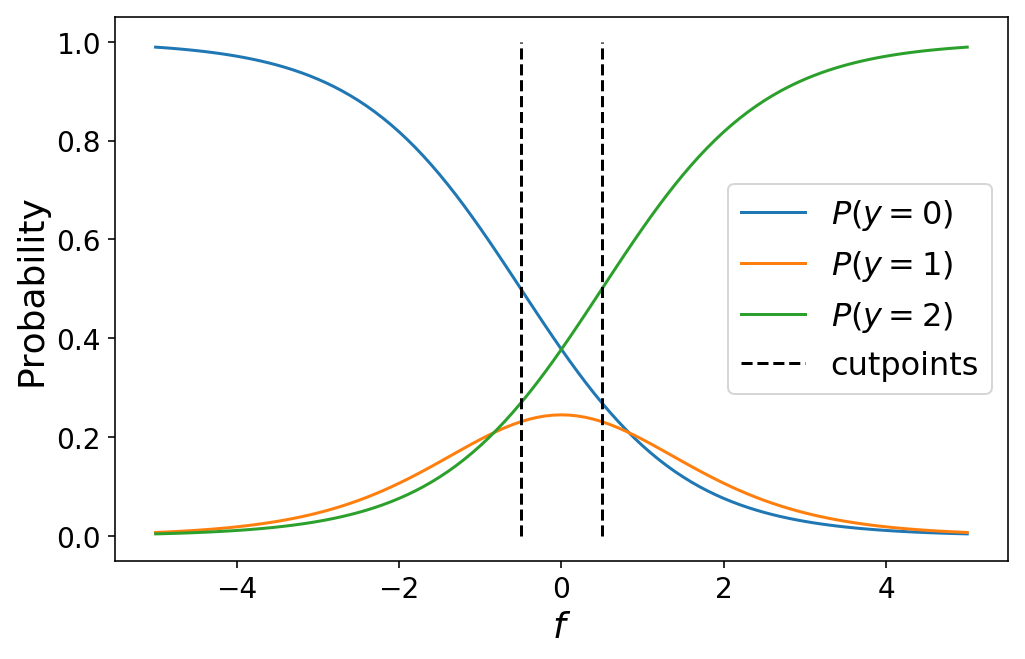

In [6]:
plot_ordinal_classes(np.linspace(-5, 5, 101), [-0.5, 0.5])

The following animation shows the class probabilities for a 5-class model as we vary the cutpoints.

<video style="display:block; width:100%; height:auto;" autoplay="" muted="" loop="loop"> 
    <source src="videos/spacecutter-ordinal-regression/ordinal_class_probabilities.mp4" type="video/mp4"> 
</video>

## Learning Ordinal Regression

Now that we have our model that predicts ordinal class probabilities, it's only a small step to _learning_ a model. We simply need to define a loss function and minimize. Our loss function will be the negative log likelihood which corresponds to the negative log of the class probability that we predict for whichever class is the "true" class for a particular observation. In pseudocode, imagine that we have three classes and a prediction `y_pred = [0.25, 0.5, 0.25]` corresponding to the predicted class probability for each of the three classes. If `y_true = 1`, then our loss is `-log(y_pred[1])`. This is easy enough to define in PyTorch, and then all we have to do is optimize both our model _and_ our cutpoints via Stochastic Gradient Descent (SGD). 

One wrinkle is that our cutpoints should be in _ascending_ order. That is, `cutpoint[0] < cutpoint[1] < ... cutpoint[K-1]`. This is a _constraint_ on our optimization problem which is not easily handled by SGD. My dirty hack is to clip the cutpoint values after each gradient update to ensure that they are always in ascending order. With more time, I'd like to implement a more [proper](https://arxiv.org/abs/1804.06500) solution.

## spacecutter

Let's recap on how we train ordinal regression models:

1. We create some model that generates a single, scalar prediction.
1. Use the cumulative logistic link function to map that scalar to ordinal class probabilities.
1. Define and minimize the negative log likelihood loss corresponding to the predictions.
1. Ensure that the `cutpoints` remain in ascending order.

Now, let's walk through how to do this in [spacecutter](https://github.com/EthanRosenthal/spacecutter). We'll use a wine quality dataset from the UCI repository in which each observation is a wine rated on a scale from 1-10. We start by downloading the dataset, inspecting some of the features, and doing some basic preprocessing of the features using the new [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) in `scikit-learn`.

In [7]:
import warnings

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from skorch.callbacks import Callback, ProgressBar
from skorch.net import NeuralNet

import torch
from torch import nn

warnings.simplefilter('ignore')

In [8]:
# Download the dataset
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

In [9]:
wine = pd.read_csv('winequality-red.csv', sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


It seems that everybody rates the wine quality somewhere between 3 and 8. We'll map these to classes 0-5. 

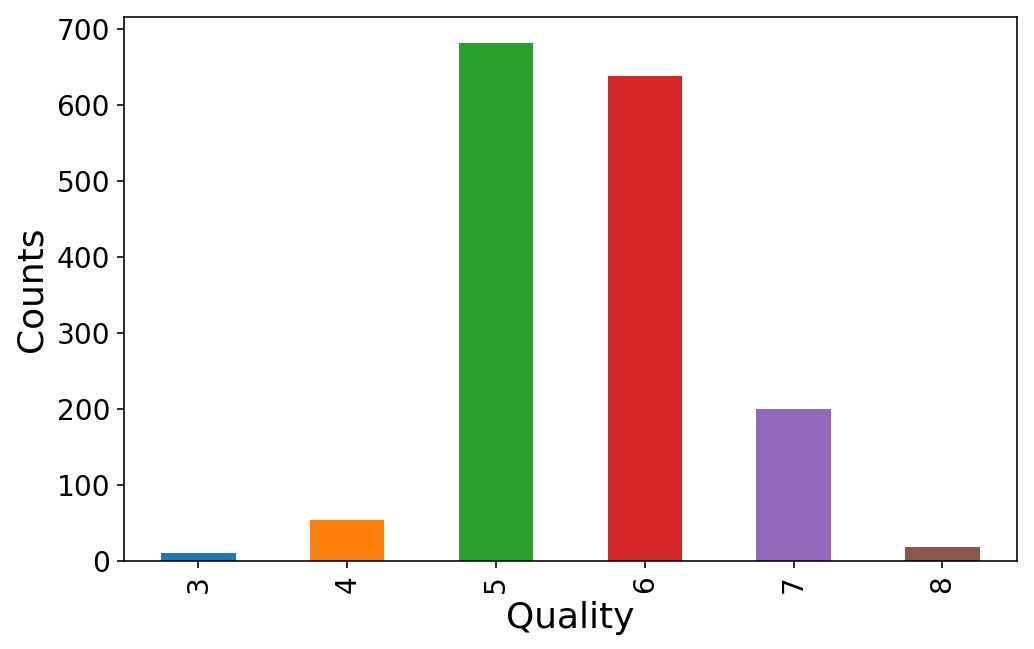

In [10]:
y = wine.pop('quality')
(y.value_counts()
  .sort_index()
  .plot(kind='bar'));
plt.ylabel('Counts');
plt.xlabel('Quality');

We'll check out the distributions of the 11 different features.

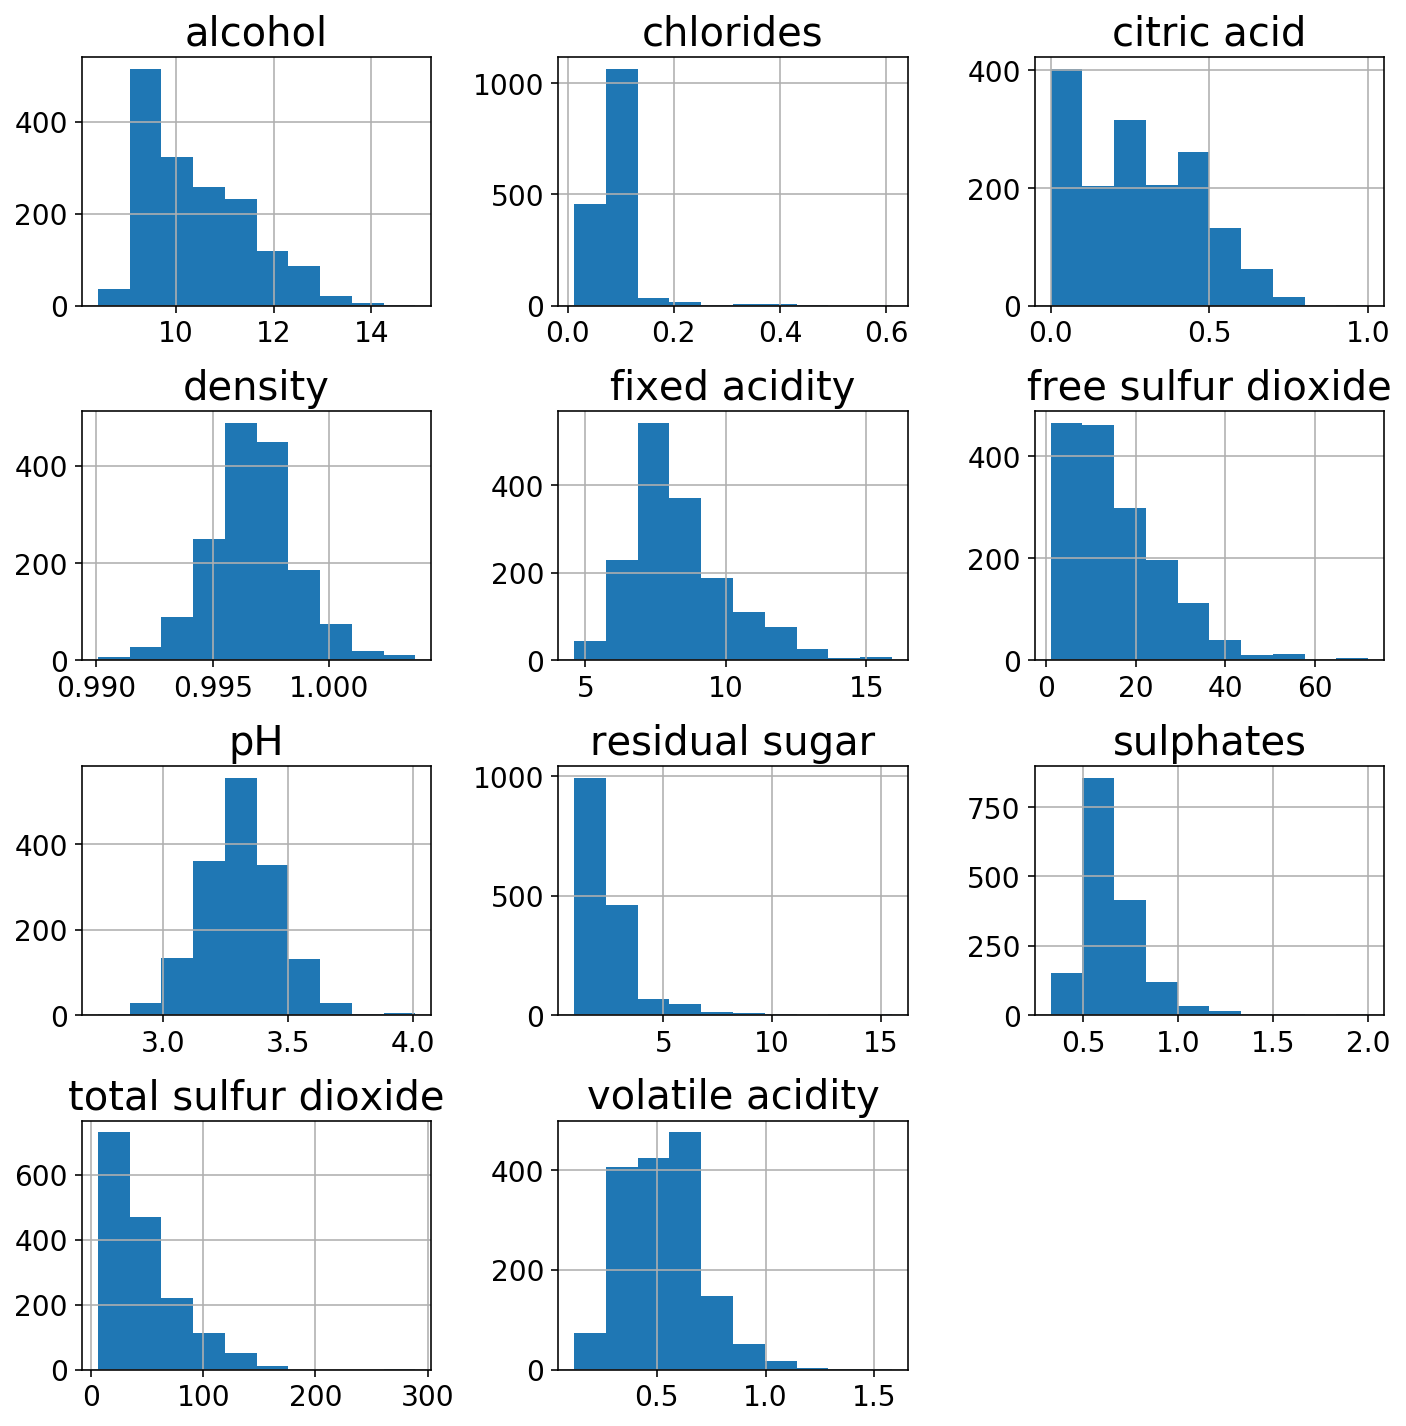

In [11]:
wine.hist(figsize=(10, 10));
plt.tight_layout();

Just to show off the power of the `ColumnTransformer`, I'll use a `StandardScaler` on the more gaussian-like columns and a `PowerTransformer` on the other ones. The transformed features look a bit more normal.

In [12]:
gaussian_columns = ['alcohol', 'chlorides', 'fixed acidity',
                    'density',
                    'pH', 'sulphates', 'volatile acidity']
power_columns = ['citric acid', 'free sulfur dioxide', 'residual sugar',
                 'total sulfur dioxide']
column_transformer = ColumnTransformer([
    ('gaussian', StandardScaler(), gaussian_columns),
    ('power', PowerTransformer(), power_columns)
])

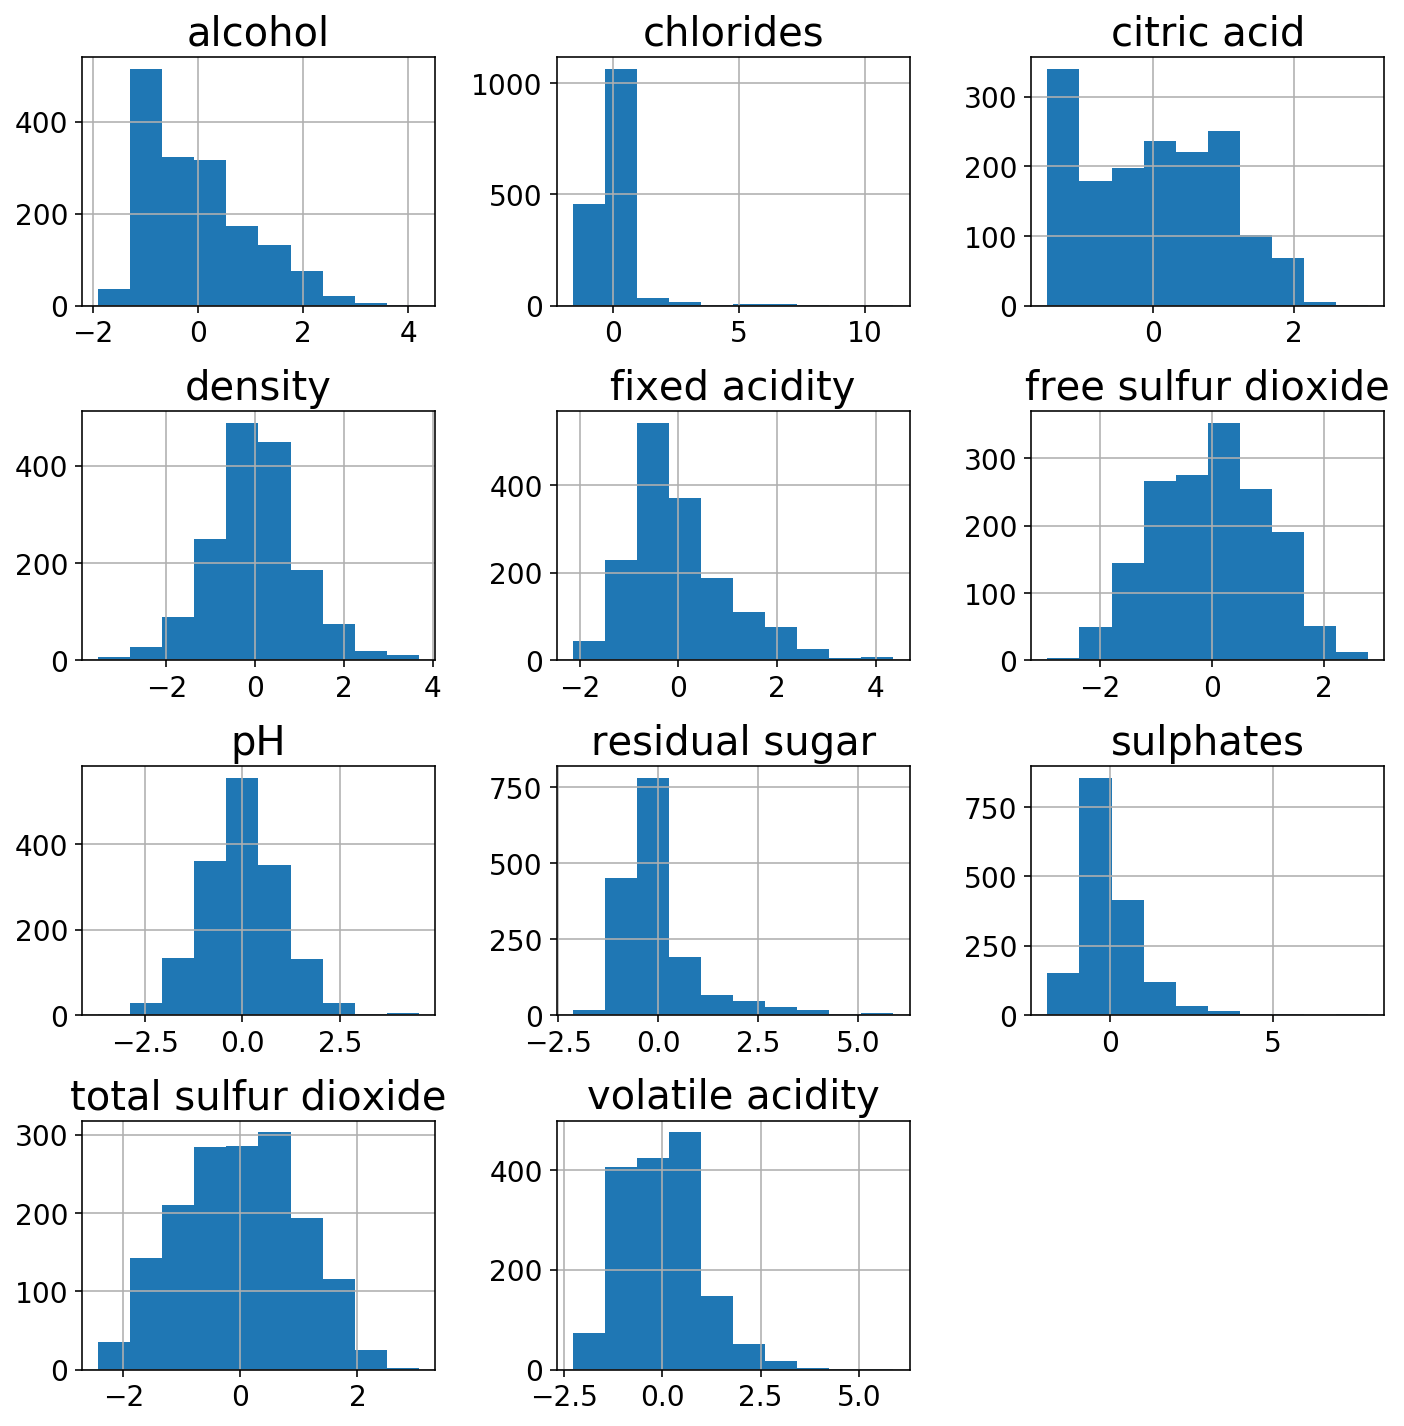

In [13]:
X_trans = column_transformer.fit_transform(wine)
(pd.DataFrame(X_trans, 
              columns=gaussian_columns + power_columns)
   .hist(figsize=(10, 10)));
plt.tight_layout();

In [14]:
y = y.values.astype(np.long).reshape(-1, 1)
# Map y from (3-8) to (0-5)
y -= y.min()

X = wine

(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.33, 
                                     stratify=y, random_state=666)

Cool, now that we have an `X` and `y` and a preprocessing transformer, we can get to training the model. Remember that the first step for ordinal regression is a model that predicts a single scalar value. I'll create a simple two-layer neural network in PyTorch for this purpose.

In [15]:
num_features = len(gaussian_columns + power_columns)

predictor = nn.Sequential(
    nn.Linear(num_features, num_features),
    nn.ReLU(inplace=True),
    nn.Linear(num_features, num_features),
    nn.ReLU(inplace=True),
    nn.Linear(num_features, 1, bias=False)
)

With `spacecutter`, we can wrap this `predictor` with the `OrdinalLogisticModel` which will create cutpoints and pass the predictor output through the cumulative logistic link function

In [16]:
from spacecutter.models import OrdinalLogisticModel

num_classes = len(np.unique(y))
model = OrdinalLogisticModel(predictor, num_classes)

X_tensor = torch.as_tensor(X_train.values.astype(np.float32))

predictor_output = predictor(X_tensor).detach()
model_output = model(X_tensor).detach()

print(predictor_output)
print(model_output)

tensor([[-4.9971],
        [-1.3892],
        [-1.9079],
        ...,
        [-3.1603],
        [-5.7689],
        [-5.1477]])
tensor([[0.9239, 0.0467, 0.0184, 0.0069, 0.0026, 0.0015],
        [0.2477, 0.2246, 0.2364, 0.1599, 0.0786, 0.0527],
        [0.3562, 0.2444, 0.2029, 0.1140, 0.0505, 0.0320],
        ...,
        [0.6593, 0.1809, 0.0944, 0.0403, 0.0157, 0.0094],
        [0.9633, 0.0228, 0.0087, 0.0032, 0.0012, 0.0007],
        [0.9339, 0.0407, 0.0159, 0.0060, 0.0022, 0.0013]])


To train this model, we'll use `skorch` which wraps our model and makes it compatible as a scikit-learn estimator. Crucially, we must pass in the `CumulativeLinkLoss` loss module from `spacecutter`. Additionally, we use a custom `spacecutter` callback `AscensionCallback` which maintains the ascending order of the cutpoints.

In [17]:
from spacecutter.losses import CumulativeLinkLoss
from spacecutter.callbacks import AscensionCallback


skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=num_classes,
    criterion=CumulativeLinkLoss,
    max_epochs=100,
    optimizer_type=torch.optim.Adam,
    optimizer__weight_decay=0.0,
    lr=0.1,
    device='cpu',
    callbacks=[
        ('ascension', AscensionCallback()),
    ],
    train_split=None,
    verbose=0,
)

The last step is to package everything up into a scikit-learn Pipeline. Note: I have to add a small transformer to make sure that the matrices are floats (and not doubles) before they're passed into the skorch model.

In [18]:
def to_float(x):
    return x.astype(np.float32)

pipeline = Pipeline([
    ('column', column_transformer),
    ('caster', FunctionTransformer(to_float)),
    ('net', skorch_model)
])

Let's use mean absolute error as our scoring critera and do a grid search across number of epochs, learning rate, and weight decay (aka ~L2 regularization).

In [19]:
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred.argmax(axis=1))

scoring = make_scorer(mae_scorer, 
                      greater_is_better=False,
                      needs_proba=True)

In [20]:
param_grid = {
    'net__max_epochs': np.logspace(1, 3, 5).astype(int),
    'net__lr': np.logspace(-4, -1, 5),
    'net__optimizer__weight_decay': np.logspace(-6, -2, 4)
}

sc_grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring,
    n_jobs=None, cv=5, verbose=1
)
sc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 92.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('column', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('gaussian', StandardScaler(copy=True, with_mean=True, with_std=True), ['alcohol', 'chlorides', 'fixed acidity', 'density', 'pH', 'sulphates', 'volatile ...as=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=11, out_features=1, bias=False)
  ),
))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'net__max_epochs': array([  10,   31,  100,  316, 1000]), 'net__lr': array([0.0001 , 0.00056, 0.00316, 0.01778, 0.1    ]), 'net__optimizer__weight_decay': array([1.00000e-06, 2.15443e-05, 4.64159e-04, 1.00000e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mae_scorer, greater_is_better=False, needs_proba=True),
       verbose=1)

Now that we're done our search (86 minutes later...), let's investigate the results.

We can see that the cutpoints are reasonably separated and in ascending order.

In [21]:
cutpoints = (sc_grid_search
             .best_estimator_
             .named_steps['net']
             .module_
             .link
             .cutpoints
             .detach())
print(f"Cutpoints: {cutpoints}")

Cutpoints: tensor([-3.3575, -2.6696, -0.1757,  1.9482,  3.6145])


The accuracy is decent for a multiclass model, and we can see that we're off in our rating prediction by less than 0.5 on average.

In [22]:
y_pred = sc_grid_search.predict_proba(X_test).argmax(axis=1)

In [23]:
print(f'Accuracy = {accuracy_score(y_test.squeeze(), y_pred):1.4f}')
print(f'MAE = {mean_absolute_error(y_test.squeeze(), y_pred):1.4f}')

Accuracy = 0.6250
MAE = 0.3958


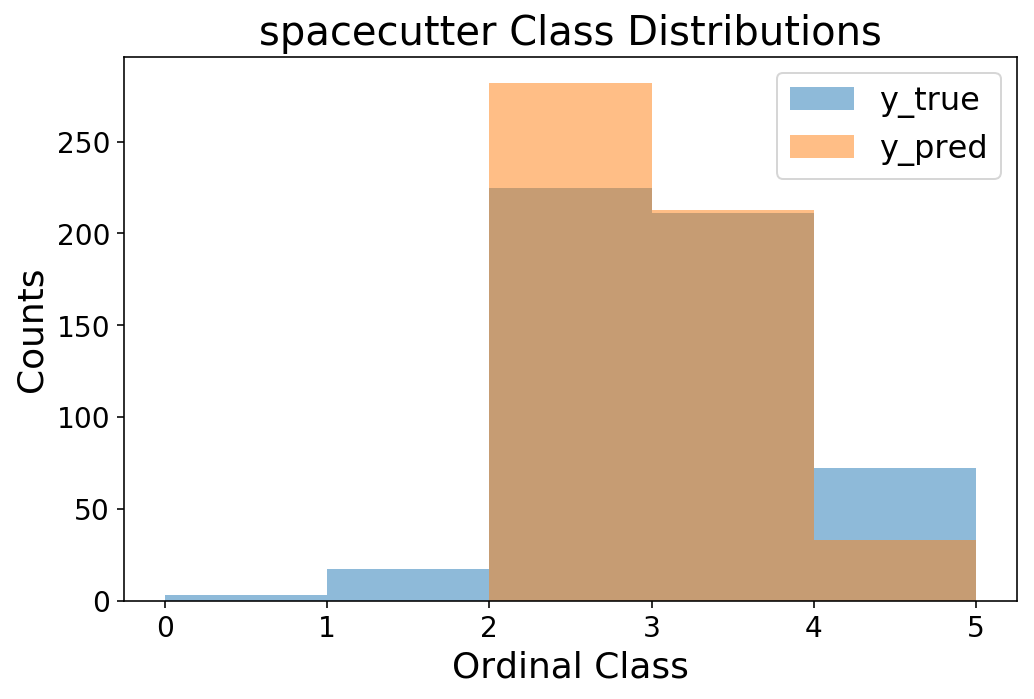

In [24]:
bins = np.arange(6)
plt.hist(y_test, bins=bins, alpha=0.5);
plt.hist(y_pred, bins=bins, alpha=0.5);
plt.legend(['y_true', 'y_pred']);
plt.ylabel('Counts');
plt.xlabel('Ordinal Class');
plt.title('spacecutter Class Distributions');

Lastly, let's do a quick check of how this compares to `mord`.

In [25]:
from mord.threshold_based import LogisticAT

pipeline = Pipeline([
    ('column', column_transformer),
    ('caster', FunctionTransformer(to_float)),
    ('model', LogisticAT())
])

In [26]:
param_grid = {
    'model__max_iter': np.logspace(3, 5, 5).astype(int),
    'model__alpha': np.logspace(0, 4, 5)
}

mord_grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring,
    n_jobs=None, cv=5, verbose=1
)
mord_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   13.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('column', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('gaussian', StandardScaler(copy=True, with_mean=True, with_std=True), ['alcohol', 'chlorides', 'fixed acidity', 'density', 'pH', 'sulphates', 'volatile ...'deprecated',
          validate=None)), ('model', LogisticAT(alpha=1.0, max_iter=1000, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'model__max_iter': array([  1000,   3162,  10000,  31622, 100000]), 'model__alpha': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mae_scorer, greater_is_better=False, needs_proba=True),
       verbose=1)

In [27]:
cutpoints = (mord_grid_search
             .best_estimator_
             .named_steps['model']
             .theta_)
print(f"Cutpoints: {cutpoints}")

Cutpoints: [-5.80087138 -3.88733054 -0.238343    2.47900366  5.45252331]


In [28]:
y_pred = mord_grid_search.predict(X_test)

In [29]:
print(f'accuracy = {accuracy_score(y_test.squeeze(), y_pred):1.3f}')
print(f'MSE = {mean_absolute_error(y_test.squeeze(), y_pred):1.3f}')

accuracy = 0.612
MSE = 0.415


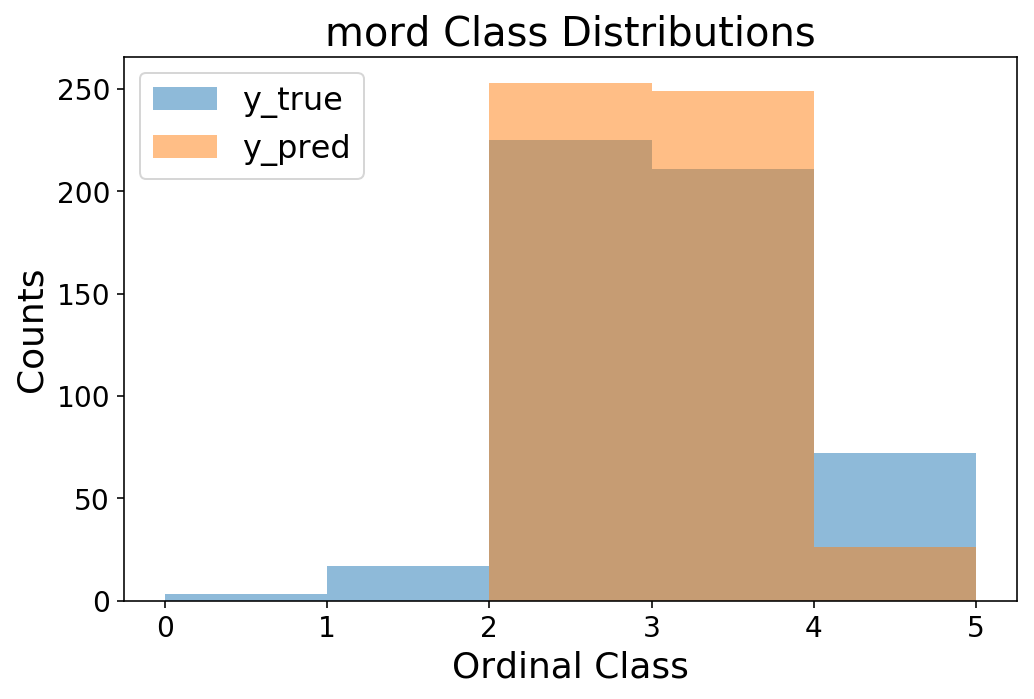

In [30]:
bins = np.arange(6)
plt.hist(y_test, bins=bins, alpha=0.5);
plt.hist(y_pred, bins=bins, alpha=0.5);
plt.legend(['y_true', 'y_pred']);
plt.ylabel('Counts');
plt.xlabel('Ordinal Class');
plt.title('mord Class Distributions');

It turns out that the results are quite comparable to `spacecutter`! Perhaps this is surprising, but we're dealing with small data and few features, so I would not expect a neural net to be particularly useful. But, it's a good sanity check that we're doing as well as a conventional linear model. Now, it's up to you to take [spacecutter](https://github.com/EthanRosenthal/spacecutter) for a spin and try scaling it up to millions of observations :)